In this file I'll do the analysis of the data I collected on Orfeo regarding the MPI barrier collective operation: in particular, the focus of the analysis will be on the average latency of the operation.

In [33]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [34]:
# Import the data collected on Orfeo
barrier_default = pd.read_csv("./Results/barrier_default.csv")
barrier_linear = pd.read_csv("./Results/barrier_linear.csv")
barrier_tree = pd.read_csv("./Results/barrier_tree.csv")
barrier_bruck = pd.read_csv("./Results/barrier_bruck.csv")
barrier_doublering = pd.read_csv("./Results/barrier_doublering.csv")

# Bind the data together in a single dataframe
barrier_results = pd.concat([barrier_default, barrier_linear, barrier_tree, barrier_bruck, barrier_doublering])

# Convert the Processes and Latency columns to int
barrier_results["Processes"] = barrier_results["Processes"].astype(int)
barrier_results["Latency"] = barrier_results["Latency"].astype(float)

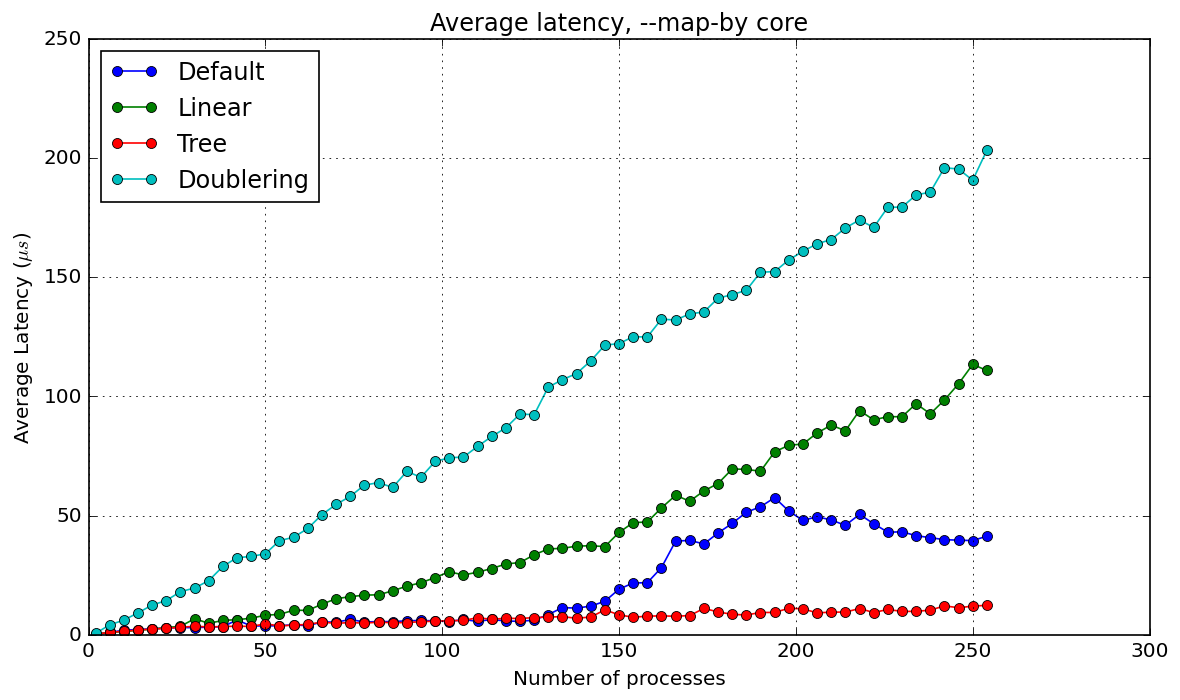

In [60]:
# Note: since we are now working with the barrier operation, we no longer have to deal with the size of the messages
# Let's now fix the map allocation to --map-by core (in fact, I obtained more consistent results and lower latencies) and 
# plot the results to compare the different algorithms' performances in terms of average latency

# Function to plot the algorithms' average latency for different map allocations against the number of processes
def algorithm_comparison(plot, i, map):
    
    # Filter the data for the given map allocation
    current_barrier = barrier_results[(barrier_results["Mapping"] == map) & (barrier_results["Processes"] != 256)]
    
    # Check if the map allocation is valid
    if current_barrier.empty:
        print("Invalid map allocation")
        return
    
    # Select the columns to plot
    x = current_barrier["Processes"].unique()
    y_default = current_barrier[current_barrier["Algorithm"] == "Default"]["Latency"]
    y_linear = current_barrier[current_barrier["Algorithm"] == "Linear"]["Latency"]
    y_tree = current_barrier[current_barrier["Algorithm"] == "Tree"]["Latency"]
    y_doublering = current_barrier[current_barrier["Algorithm"] == "DoubleRing"]["Latency"]
    
    # Create a 2D plot
    ax = plot.add_subplot(1, 1, i+1)
    
    # Plot the data and set the labels
    ax.plot(x, y_default, label="Default", marker="o")
    ax.plot(x, y_linear, label="Linear", marker="o")
    ax.plot(x, y_tree, label="Tree", marker="o")
    ax.plot(x, y_doublering, label="Doublering", marker="o")
    ax.set_xlabel("Number of processes")
    ax.set_ylabel("Average Latency ($\mu s$)")
    ax.set_title(f"Average latency, --map-by {map}")
    ax.legend()
    ax.legend(loc="upper left")
    plt.grid(True)
    
# Create a single figure to plot the results
plt.style.use("classic")
plot = plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='k')

# Plot the results 
algorithm_comparison(plot, 0, "core")

# Fix the layout and show the plot
plt.tight_layout()
plt.show()
    

In [ ]:
# We can now compare the different algorithms' performances in terms of average latency: the Tree algorithm seems to be the best one
# for the barrier operation, as it provides the lowest average latency for all the number of processes

# A note on the map allocation: here we focused on the --map-by core allocation, because from the collected data that 
# was the one that in general provided the lowest average latency. In fact, the --map-by socket allocation provided
# higher average latencies for the same message size and number of processes

In [64]:
# Let's not try to build a model to predict the average latency of the barrier operation based on the number of processes; I will use a linear regression 
# model, building a model for each algorithm

# Function to build a linear regression model for the average latency of the barrier operation
def barrier_model(algorithm, map, quadratic=False):
    
    # Select the data for the current algorithm
    current_barrier = barrier_results[(barrier_results["Algorithm"] == algorithm) & (barrier_results["Mapping"] == map)]
    
    # Check if the data exists
    if current_barrier.empty:
        print(f"No data found for {algorithm}")
        return
    
    # Select as response variable the average latency
    y = current_barrier["Latency"]
    
    # Select as predictor the number of processes
    # We don't insert the intercept in the model, since the average latency should be 0 when the number of processes is 0
    x = pd.DataFrame(current_barrier["Processes"])
    
    # If requested, add the quadratic term to the model
    if quadratic==True:
        x["Processes^2"] = x["Processes"]**2
    # In general, the quadratic term appeared to be not significant or useful, so I will not use it
    
    # Build the model
    return sm.OLS(y, x).fit()

# Build the model for the linear algorithm and the --map-by core allocation
model_default = barrier_model("Linear", "core", quadratic=False)

# Print the summary of the model
print(f"Model for Default algorithm, --map-by core allocation")
print(model_default.summary())
print("\n")

Model for Default algorithm, --map-by core allocation
                                 OLS Regression Results                                
Dep. Variable:                Latency   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                              1732.
Date:                Mon, 11 Mar 2024   Prob (F-statistic):                    4.58e-48
Time:                        22:32:23   Log-Likelihood:                         -245.77
No. Observations:                  65   AIC:                                      493.5
Df Residuals:                      64   BIC:                                      495.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025

In [51]:
# Build the model for the tree algorithm and the --map-by core allocation
model_tree = barrier_model("Tree", "core", quadratic=False)

# Print the summary of the model
print(f"Model for Tree algorithm, --map-by core allocation")
print(model_tree.summary())
print("\n")

Model for Tree algorithm, --map-by core allocation
                                 OLS Regression Results                                
Dep. Variable:                Latency   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.974
Method:                 Least Squares   F-statistic:                              2464.
Date:                Mon, 11 Mar 2024   Prob (F-statistic):                    8.11e-53
Time:                        21:45:24   Log-Likelihood:                         -105.57
No. Observations:                  65   AIC:                                      213.1
Df Residuals:                      64   BIC:                                      215.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025   

In [52]:
# Build the model for the double_ring algorithm and the --map-by core allocation
model_doublering = barrier_model("DoubleRing", "core", quadratic=False)

# Print the summary of the model
print(f"Model for DoubleRing algorithm, --map-by core allocation")
print(model_doublering.summary())
print("\n")

Model for DoubleRing algorithm, --map-by core allocation
                                 OLS Regression Results                                
Dep. Variable:                Latency   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          6.989e+04
Date:                Mon, 11 Mar 2024   Prob (F-statistic):                    5.77e-99
Time:                        21:46:11   Log-Likelihood:                         -174.88
No. Observations:                  65   AIC:                                      351.8
Df Residuals:                      64   BIC:                                      353.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.

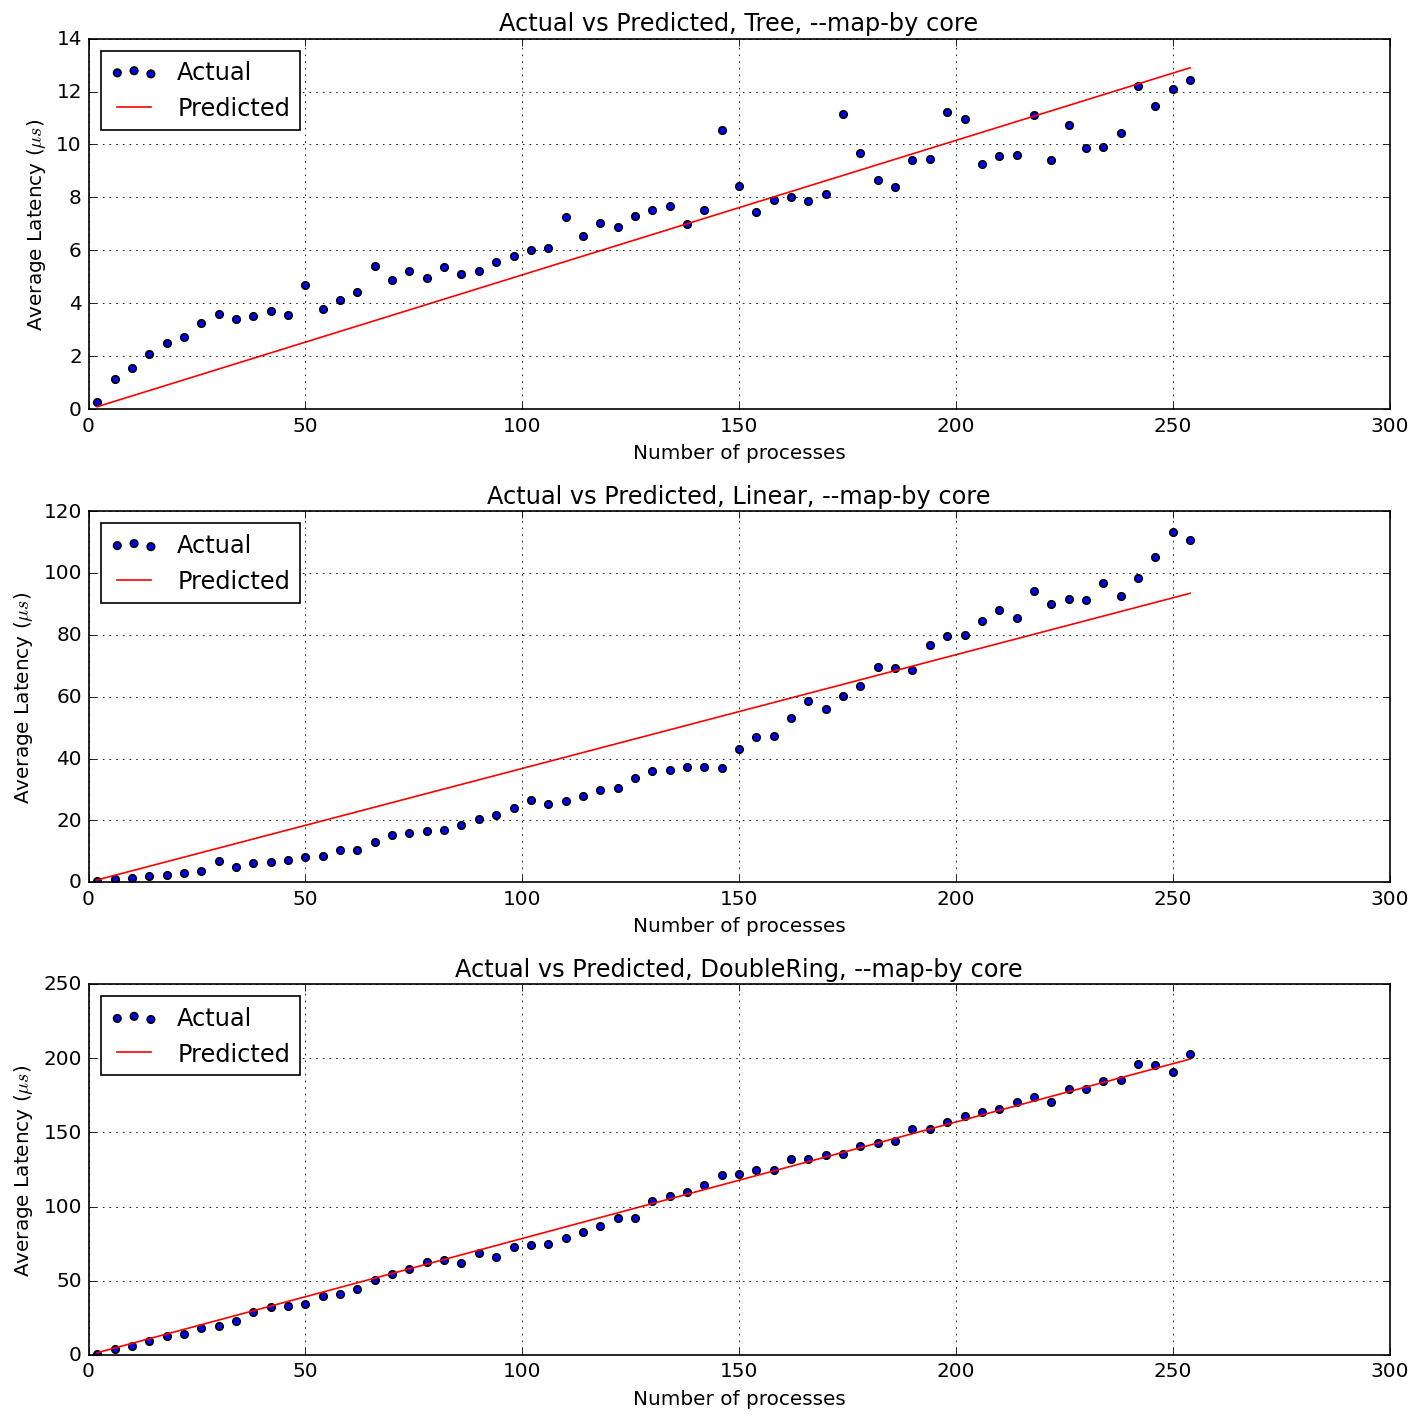

In [65]:
# Let's now plot the models' predictions against the actual results; I'll plot the actual average latency with scatter plots and the models' predictions with lines

# Function to plot the models' predictions against the actual results
def plot_model(plot, model, algorithm, map, i):
    
    # Select the data for the current algorithm
    current_barrier = barrier_results[(barrier_results["Algorithm"] == algorithm) & (barrier_results["Mapping"] == map) & (barrier_results["Processes"] != 256)]
    
    # Check if the data exists
    if current_barrier.empty:
        print(f"No data found for {algorithm}")
        return
    
    # Select the columns to plot
    x = current_barrier["Processes"].unique()
    y = current_barrier[current_barrier["Algorithm"] == algorithm]["Latency"]
    
    # Create a 2D plot
    ax = plot.add_subplot(3, 1, i+1)
    
    # Plot the data and set the labels
    ax.scatter(x, y, label="Actual", marker="o")
    ax.plot(x, model.predict(pd.DataFrame(x)), label="Predicted", color="red")
    ax.set_xlabel("Number of processes")
    ax.set_ylabel("Average Latency ($\mu s$)")
    ax.set_title(f"Actual vs Predicted, {algorithm}, --map-by {map}")
    ax.set_xlim(0, 300)
    ax.set_ylim(0,)
    ax.legend()
    ax.legend(loc="upper left")
    plt.grid(True)
    
# Create a single figure to plot the results
plt.style.use("classic")
plot = plt.figure(figsize=(12, 12), dpi=120, facecolor='w', edgecolor='k')

# Plot the results
plot_model(plot, model_tree, "Tree", "core", 0)
plot_model(plot, model_default, "Linear", "core", 1)
plot_model(plot, model_doublering, "DoubleRing", "core", 2)

# Fix the layout and show the plot
plt.tight_layout()
plt.show()
    
